<img src="logo_LNEC.png" alt="LNEC" width="200" align="right"/>

# ERIES - RE-SAFE PROJECT - Claudio Mazzotti (_Università di Bologna_)

## Specimen for the shake table test

The RC frame specimen is built at a scale of 2/3 using the Cauchy-Froude similitude law.

## Shake table input motions

Two different earthquake records are under consideration for the shake table test at LNEC:

1. The 2009 L'Aquila earthquake (L'AQUILA-IT.AVZ.00.HNN.D.IT-2009)

0. The 1976 Friuli earthquake (TOLMEZZO)

## Computational environment

In [8]:
# Developed for Python 3.12.4
from __future__ import annotations

# Python standard library
import os
import sys
import datetime

from pathlib import Path

# 3rd party modules
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl

from scipy import constants
from scipy.signal import butter, sosfiltfilt, periodogram, resample
from scipy.signal.windows import tukey

import matplotlib.pyplot as plt

# pxc modules
if (ppfolder := str(Path('..') / 'personal_python_packages')) not in sys.path:
    sys.path.append(ppfolder)


import utilities
import LNECSPA
from utilities import maxabs
from LNECSPA import LTFdb

# missing imports
""" import PPcore
import RSnumba
import DSP
import LNEC3DST
from RSnumba import cts as RScalc
from DSP import FrequencyDomain, dBpow

# print environment
PPcore.environment(globals()) """

' import PPcore\nimport RSnumba\nimport DSP\nimport LNEC3DST\nfrom RSnumba import cts as RScalc\nfrom DSP import FrequencyDomain, dBpow\n\n# print environment\nPPcore.environment(globals()) '

In [2]:
# Data for the response spectra
ff = np.geomspace(0.1, 40., num=200) # Hz
TT = 1. / ff # s
ww = 2. * np.pi * ff # rad/s
zn = 0.05 # damping coefficient

# Data for the scaled motions
SF = 2. / 3. # 1:1.5 scale factor

# Data for the LNEC3D shake table
Fs = 20e3 #LNEC3DST.STfs # control system samplig frequency

## _`Scalato`_ time series supplied

In [3]:
fp = r"C:\Users\afons\OneDrive - Universidade de Lisboa\Controlo de Plataforma Sismica\LNEC_Adapta_Driver\LNEC_ERIES_RE-SAFE\ProposedMotions"

with pd.ExcelFile(Path(fp) / "L'AQUILA-IT.AVZ.00.HNN.D.IT-2009.xlsx") as reader:
    dfA2 = reader.parse('Scalato', index_col=0, usecols='A:D')

with pd.ExcelFile(Path(fp) / "TOLMEZZO.xlsx") as reader:
    dfT2 = reader.parse('Scalato', index_col=0, usecols='A:D')


## Data processing for the LNEC 3D shake table based on the _scalato_ signals

The following processing steps are taken:

1. Apply low pass digital filter (Butterworth) to displacement time series (corner frequency = 40Hz * sqrt(2/3))

1. Apply Tukey window (20% in L'Aquila record, 10% in Tolmezzo record)

1. Resample for 200 Hz (LNEC 3D shake table control requirement)

1. Compute velocity and acceleration time series (differentiation in the frequency domain)

1. Compute pseudo acceleration response spectra

### L'AQUILA-IT.AVZ.00.HNN.D.IT-2009

Processed time series

In [4]:
ttA2 = dfA2.index
dtA2 = ttA2[1] - ttA2[0]
SpoA2 = dfA2['Spo'].to_numpy()

sos = butter(8, 40.*np.sqrt(SF), output='sos', fs=1./dtA2)
SpoA3 = sosfiltfilt(sos, SpoA2, padtype='even')

SpoA3 *= tukey(SpoA3.size, alpha=0.2) # 20% Tukey window

SpoA3, ttA3 = resample(SpoA3, int(ttA2.size*np.sqrt(SF)), ttA2)
dtA3 = ttA3[1] - ttA3[0]
print(dtA3) # before rounding

dtA3 = np.round(dtA3, decimals=3)
ttA3 = dtA3 * np.arange(ttA3.size)
print(ttA2[-1], ttA3[-1], dtA3, ttA3.size) # after rounding

VelA3 = FrequencyDomain.differentiate(SpoA3, dt=dtA3)
AccA3 = FrequencyDomain.differentiate(VelA3, dt=dtA3)

fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(18,6), layout='constrained')
ax[-1].set_xlabel('Time (s)')

for axis, column, ts, units in zip(ax, ('Spo', 'Vel', 'Acc'), (SpoA3, VelA3, AccA3), ('cm', 'cm/s', 'cm/s²')):
    axis.plot(dfA2[column], label=f'Scalato (peak={maxabs(dfA2[column]):.1f}{units})')
    axis.plot(ttA3, ts, label=f'Processed (peak={maxabs(ts):.1f}{units})')
    axis.set_ylabel(f'{column} ({units})')
    axis.legend(loc='upper right')
    axis.grid(visible=True)


0.0050001552475984826
44.90731195103284 44.905 0.005 8982


NameError: name 'FrequencyDomain' is not defined

Power spectral density

In [ ]:
fA2, PxxA2 = periodogram(dfA2['Acc'], fs=1./dtA2)
fA3, PxxA3 = periodogram(AccA3, fs=1./dtA3)

fig, ax = plt.subplots(figsize=(18,4), layout='constrained')
ax.plot(fA2, dBpow(PxxA2), label='Scalato')
ax.plot(fA3, dBpow(PxxA3), label='Processed')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('PSD (dB((cm/s²)²/Hz))')
ax.set_ylim((-120., None))
ax.legend(loc='upper right')
ax.grid(visible=True)

Response spectra

NameError: name 'AccA3' is not defined

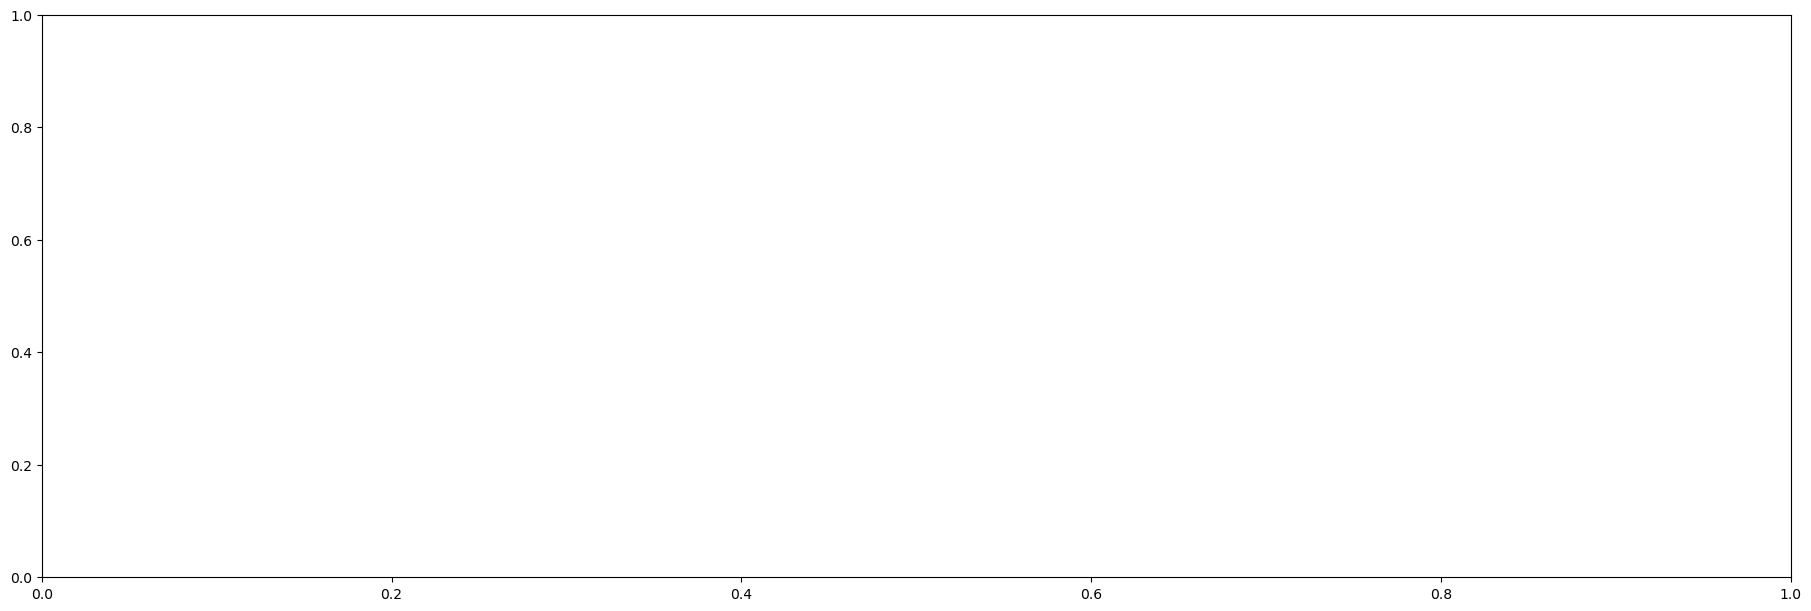

In [5]:
fig, ax = plt.subplots(figsize=(18,6), layout='constrained')

for acc, dt, name in zip((dfA2['Acc'].to_numpy(), AccA3.copy()), (dtA2, dtA3), ('Scalato', 'Processed')):
    acc /= 100. # cm/s² -> m/s²
    rsd = RScalc(acc, dt, ww, zn)[:, 0] * 100. # m -> cm
    rsa = rsd * ww ** 2 # cm/s²
    ax.plot(TT, rsa, label=name)

ax.set_title('Response spectra')
ax.set_xlabel('Period (s)')
ax.set_ylabel('Pseudo-acceleration (cm/s²)')
ax.legend(loc='upper right')
ax.grid(visible=True)

Export data

In [6]:
dfA3 = pd.DataFrame(data=(SpoA3, VelA3, AccA3), index=('Spo (cm)', 'Vel (cm/s)', 'Acc (cm/s²)'), columns=ttA3).T
dfA3.index.name = 'Time (s)'
dfA3RS = pd.DataFrame(data=rsa, index=TT, columns=('Acc (cm/s²)',))
dfA3RS.index.name = 'Time (s)'

with pd.ExcelWriter("L'AQUILA-IT.AVZ.00.HNN.D.IT-2009_LNEC3D.xlsx") as writer:
    dfA3.to_excel(writer, sheet_name='Time series', index=True)
    dfA3RS.to_excel(writer, sheet_name='Response spectrum', index=True)

# LTF file
ltfA = LTFdb()
ltfA.update(AQTD=['AQTD'],
            stage=["L'AQUILA-IT.AVZ.00.HNN.D.IT-2009 seismic record, scale factor 2/3, Cauchy+Froude similitude law"],
            obs=['ERIES RE-Safe project'],
            date=[str(datetime.datetime.now())],
            t0=np.repeat(ltfA.t0, 3),
            dt=np.repeat(ltfA.dt*0.005, 3),
            dataformat=np.repeat(ltfA.dataformat, 3),
            IDstring=ltfA.IDstring*3,
            scalefactor=np.repeat(ltfA.scalefactor, 3),
            offset=np.repeat(ltfA.offset, 3),
            data=np.vstack((SpoA3*10., VelA3, AccA3/100./constants.g)),
            names=['DispT', 'VelT', 'AccT'],
            units=['mm', 'cm/s', 'g'],
            types=['Displacement', 'Velocity', 'Acceleration'],
            info=[f'PGD={maxabs(SpoA3*10.):.0f}mm', f'PGV={maxabs(VelA3):.2f}cm/s', f'PGA={maxabs(AccA3/100./constants.g):.3f}g'],
            )
ltfA.write('LAquilaReducedScale.ltf')

# LNEC3D shake table target motion file
tgtA = LTFdb()
tgtA.update(AQTD=['AQTD'],
            stage=["L'AQUILA-IT.AVZ.00.HNN.D.IT-2009 seismic record, scale factor 2/3, Cauchy+Froude similitude law"],
            obs=['ERIES RE-Safe project'],
            date=[str(datetime.datetime.now())],
            t0=np.repeat(tgtA.t0, 6),
            dt=np.repeat(tgtA.dt*0.005, 6),
            dataformat=np.repeat(tgtA.dataformat, 6),
            IDstring=tgtA.IDstring*6,
            scalefactor=np.repeat(tgtA.scalefactor, 6),
            offset=np.repeat(tgtA.offset, 6),
            data=np.vstack((SpoA3*10., SpoA3*0., SpoA3*0., AccA3/100./constants.g, AccA3*0., AccA3*0.)),
            names=['DispT', 'DispL', 'DispV', 'AccT', 'AccL', 'AccV'],
            units=['mm']*3 + ['g']*3,
            types=['Displacement']*3 + ['Acceleration']*3,
            info=tgtA.info*6,
            )
tgtA.write('LAquilaReducedScale.tgt')

NameError: name 'VelA3' is not defined

Check LNEC3D shake table target motion file

In [7]:
tgtA = LTFdb()
tgtA.read(r'C:\Users\afons\OneDrive - Universidade de Lisboa\Controlo de Plataforma Sismica\LNEC_Adapta_Driver\LNEC_ERIES_RE-SAFE\CTL\Targets\LAquilaReducedScale.tgt')
print(tgtA)
print()
tgtA.print_metadata()

Filename: C:\Users\afons\OneDrive - Universidade de Lisboa\Controlo de Plataforma Sismica\LNEC_Adapta_Driver\LNEC_ERIES_RE-SAFE\CTL\Targets\LAquilaReducedScale.tgt
AQTD: ['AQTD']
Stage: ["L'AQUILA-IT.AVZ.00.HNN.D.IT-2009 seismic record, scale factor 2/3, Cauchy+Froude similitude law"]
Obs: ['ERIES RE-Safe project']
Date: ['2024-09-06 12:13:12.934830']
Signals: 6

AQTD: ['AQTD']
Stage: ["L'AQUILA-IT.AVZ.00.HNN.D.IT-2009 seismic record, scale factor 2/3, Cauchy+Froude similitude law"]
Obs: ['ERIES RE-Safe project']
Date: ['2024-09-06 12:13:12.934830']
t0: [(0, 0) (0, 0) (0, 0) (0, 0) (0, 0) (0, 0)]
dt: [0.005 0.005 0.005 0.005 0.005 0.005]
Cluster: [(1.9440926740509248, 1.6826159119301773, array([5514, 5514, 5514, ..., 5514, 5514, 5514], dtype=int16)), (1.0, 0.0, array([0, 0, 0, ..., 0, 0, 0], dtype=int16)), (1.0, 0.0, array([0, 0, 0, ..., 0, 0, 0], dtype=int16)), (0.006608805059949585, 0.4583040592585605, array([1501, 1500, 1499, ..., 1493, 1495, 1499], dtype=int16)), (1.0, 0.0, array([

### TOLMEZZO

Processed time series

In [ ]:
ttT2 = dfT2.index
dtT2 = ttT2[1] - ttT2[0]
SpoT2 = dfT2['Spo'].to_numpy()

sos = butter(8, 40.*np.sqrt(SF), output='sos', fs=1./dtT2)
SpoT3 = sosfiltfilt(sos, SpoT2, padtype='even')

SpoT3 *= tukey(SpoT3.size, alpha=0.1) # 10% Tukey window

SpoT3, ttT3 = resample(SpoT3, int(ttT2.size*np.sqrt(SF)), ttT2)
dtT3 = ttT3[1] - ttT3[0]
print(dtT3) # before rounding

dtT3 = np.round(dtT3, decimals=3)
ttT3 = dtT3 * np.arange(ttT3.size)
print(ttT2[-1], ttT3[-1], dtT3, ttT3.size) # after rounding

VelT3 = FrequencyDomain.differentiate(SpoT3, dt=dtT3)
AccT3 = FrequencyDomain.differentiate(VelT3, dt=dtT3)

fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(18,6), layout='constrained')
ax[-1].set_xlabel('Time (s)')

for axis, column, ts, units in zip(ax, ('Spo', 'Vel', 'Acc'), (SpoT3, VelT3, AccT3), ('cm', 'cm/s', 'cm/s²')):
    axis.plot(dfT2[column], label=f'Scalato (peak={maxabs(dfT2[column]):.1f}{units})')
    axis.plot(ttT3, ts, label=f'Processed (peak={maxabs(ts):.1f}{units})')
    axis.set_ylabel(f'{column} ({units})')
    axis.legend(loc='upper right')
    axis.grid(visible=True)


Power spectral density

In [ ]:
fT2, PxxT2 = periodogram(dfT2['Acc'], fs=1./dtT2)
fT3, PxxT3 = periodogram(AccT3, fs=1./dtT3)

fig, ax = plt.subplots(figsize=(18,4), layout='constrained')
ax.plot(fT2, dBpow(PxxT2), label='Scalato')
ax.plot(fT3, dBpow(PxxT3), label='Processed')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('PSD (dB((cm/s²)²/Hz))')
ax.set_ylim((-120., None))
ax.legend(loc='upper right')
ax.grid(visible=True)

Response spectra

In [ ]:
fig, ax = plt.subplots(figsize=(18,6), layout='constrained')

for acc, dt, name in zip((dfT2['Acc'].to_numpy(), AccT3.copy()), (dtT2, dtT3), ('Scalato', 'Processed')):
    acc /= 100. # cm/s² -> m/s²
    rsd = RScalc(acc, dt, ww, zn)[:, 0] * 100. # m -> cm
    rsa = rsd * ww ** 2 # cm/s²
    ax.plot(TT, rsa, label=name)

ax.set_title('Response spectra')
ax.set_xlabel('Period (s)')
ax.set_ylabel('Pseudo-acceleration (cm/s²)')
ax.legend(loc='upper right')
ax.grid(visible=True)

Export data

In [ ]:
dfT3 = pd.DataFrame(data=(SpoT3, VelT3, AccT3), index=('Spo (cm)', 'Vel (cm/s)', 'Acc (cm/s²)'), columns=ttT3).T
dfT3.index.name = 'Time (s)'
dfT3RS = pd.DataFrame(data=rsa, index=TT, columns=('Acc (cm/s²)',))
dfT3RS.index.name = 'Time (s)'

with pd.ExcelWriter('TOLMEZZO_LNEC3D.xlsx') as writer:
    dfT3.to_excel(writer, sheet_name='Time series', index=True)
    dfT3RS.to_excel(writer, sheet_name='Response spectrum', index=True)

# LTF file
ltfT = LTFdb()
ltfT.update(AQTD=['AQTD'],
            stage=["L'AQUILA-IT.AVZ.00.HNN.D.IT-2009 seismic record, scale factor 2/3, Cauchy+Froude similitude law"],
            obs=['ERIES RE-Safe project'],
            date=[str(datetime.datetime.now())],
            t0=np.repeat(ltfT.t0, 3),
            dt=np.repeat(ltfT.dt*0.005, 3),
            dataformat=np.repeat(ltfT.dataformat, 3),
            IDstring=ltfT.IDstring*3,
            scalefactor=np.repeat(ltfT.scalefactor, 3),
            offset=np.repeat(ltfT.offset, 3),
            data=np.vstack((SpoT3*10., VelT3, AccT3/100./constants.g)),
            names=['DispT', 'VelT', 'AccT'],
            units=['mm', 'cm/s', 'g'],
            types=['Displacement', 'Velocity', 'Acceleration'],
            info=[f'PGD={maxabs(SpoT3*10.):.0f}mm', f'PGV={maxabs(VelT3):.1f}cm/s', f'PGA={maxabs(AccT3/100./constants.g):.3f}g'],
            )
ltfT.write('TolmezzoReducedScale.ltf')

# LNEC3D shake table target motion file
tgtT = LTFdb()
tgtT.update(AQTD=['AQTD'],
            stage=['Tolmezzo seismic record, scale factor 2/3, Cauchy+Froude similitude law'],
            obs=['ERIES RE-Safe project'],
            date=[str(datetime.datetime.now())],
            t0=np.repeat(tgtT.t0, 6),
            dt=np.repeat(tgtT.dt*0.005, 6),
            dataformat=np.repeat(tgtT.dataformat, 6),
            IDstring=tgtT.IDstring*6,
            scalefactor=np.repeat(tgtT.scalefactor, 6),
            offset=np.repeat(tgtT.offset, 6),
            data=np.vstack((SpoT3*10., SpoT3*0., SpoT3*0., AccT3/100./constants.g, AccT3*0., AccT3*0.)),
            names=['DispT', 'DispL', 'DispV', 'AccT', 'AccL', 'AccV'],
            units=['mm']*3 + ['g']*3,
            types=['Displacement']*3 + ['Acceleration']*3,
            info=tgtT.info*6,
            )
tgtT.write('TolmezzoReducedScale.tgt')

Check LNEC3D shake table target motion file

In [ ]:
tgtT = LTFdb()
tgtT.read('TolmezzoReducedScale.tgt')
print(tgtT)
print()
tgtT.print_metadata()

This [Jupyter Notebook](https://jupyter.org/) developed in [Python](https://www.python.org/) was created by [Paulo Xavier Candeias](https://www.lnec.pt/estruturas/en/team/paulo-xavier-candeias/) at [LNEC](https://www.lnec.pt/en/). Licensed under [GPLv3](https://www.gnu.org/licenses/gpl-3.0.en.html) and [CC-BY-SA](https://creativecommons.org/licenses/by-sa/4.0/):

<a rel="license" href="https://www.gnu.org/licenses/gpl-3.0.en.html"><img alt="GNU General Public License" style="border-width:0" src="https://www.gnu.org/graphics/gplv3-or-later.png" /></a><br />This work is licensed under a <a rel="license" href="https://www.gnu.org/licenses/gpl-3.0.en.html">GNU General Public License v3 or later</a>.

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.